Preface

这个notebook是为了工作面试的家庭作业而设计的。这个问题是一个经典的多类分类(不是积极/消极的预测，而是逐渐从0到4的情绪量表)。最直接的方式解决这是使用一些分类algorythm,像k - means,不过我最近做了蕴藏在深度学习和情感分析的主题(Udacity深度学习Nanodegree奖学金挑战,课上情绪分析RNN),所以我决定尝试和应用方法。此外，循环神经网络(RNN)在这类任务中具有较高的准确性。



如果需要，我将使用Pytorch库进行模型构建，使用NLTK进行文本预处理。为了节省时间，我也不会尝试重新发明轮子，而是重用来自在线资源和Udacity课程材料的代码示例。



从排行榜来看，任何高于0.65分的成绩都可以认为是本次比赛的好成绩，所以我将以此为基准来评判我的model表现。

In [11]:
import numpy as np
import pandas as pd

import unicodedata, re, string
import nltk

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.listdir(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\dataset"))

['test.tsv', 'train.tsv']


In [3]:
df_train = pd.read_csv(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\dataset\train.tsv", sep="\t")
df_test = pd.read_csv(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\dataset\test.tsv", sep="\t")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [5]:
df_train.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [6]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
df_train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [8]:
df_train.loc[df_train['SentenceId'] == 1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


正如在最初的竞赛描述中所提到的，没有单独的电影评论，而是断章取义，分成更小的部分，每个部分都有指定的情感类别。比赛是根据每个测试阶段的评分结果进行评估的，因此在这里，整个评审的上下文并不重要。数据也相当干净，因此不需要太多的预处理。在继续之前，最好先看看数据的分布，看看训练集中的类是否均匀分布。为此，我借用了Kaggle另一个内核的代码:

In [27]:
# 建立一个词典key为Sentiment值，value为该Sentiment值的个数
dist = df_train.groupby(["Sentiment"]).size()
dist

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
dtype: int64

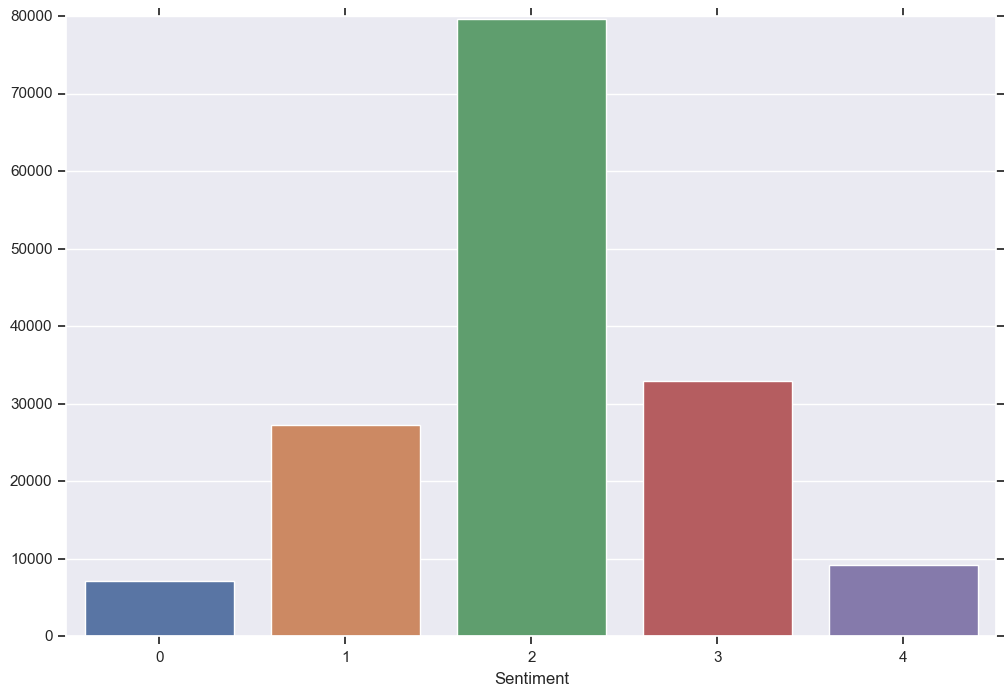

In [12]:
# seaborn高效绘图
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

类似乎遵循正态分布，最常见的分布是“2”。这可能导致模型没有足够的数据来学习较少表示的类。在评估模型时要注意这一点。

预处理

单词需要标记成数字格式，然后传递给RNN。在此之前，我还将过滤掉空格和标点符号，并使用lemm进一步降低维度。此时，我不想过滤掉“停止词”，因为RNN善于从以前遇到的信息中学习上下文。在电影评论中，短语"this movie is shit"与"this movie is the shit"有相反的意思，所以我希望模型可以获得这些信息。

以下是我从网上借来的一些帮助准备数据的辅助功能:

In [13]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words 从分词列表中删除非ascii字符"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words 从分词列表中删除标点符号"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words 词干"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words 词原型 """
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

首先，遍历dataframe并使用NLTK分词。然后将通过之前创建的预处理函数处理每个分词，最终结果是一个简化的分词列表:

In [14]:
# First step - tokenizing phrases
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)

# Second step - passing through prep functions
df_train['Words'] = df_train['Words'].apply(normalize) 
df_train['Words'].head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Words, dtype: object

将单词转换为数字表示形式，因为嵌入查找要求将整数传递到网络。最简单的方法是创建字典，将词汇表中的单词映射到整数。使用这个词典，那么每个短语中的单词可以转换成整数:

In [15]:
# Third step - creating a list of unique words to be used as dictionary for encoding
word_set = set()
for l in df_train['Words']:
    for e in l:
        word_set.add(e)
        
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}

# Check if they are still the same lengh
print(len(word_set))
print(len(word_to_int))

16209
16209


In [28]:
# import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [33]:
# sentences = [['first', 'sentence'], ['second', 'sentence']]
# model = gensim.models.Word2Vec(sentences, workers=6)

2019-12-03 17:41:20,710 : INFO : collecting all words and their counts
2019-12-03 17:41:20,710 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-03 17:41:20,711 : INFO : collected 3 word types from a corpus of 4 raw words and 2 sentences
2019-12-03 17:41:20,712 : INFO : Loading a fresh vocabulary
2019-12-03 17:41:20,712 : INFO : effective_min_count=5 retains 0 unique words (0% of original 3, drops 3)
2019-12-03 17:41:20,713 : INFO : effective_min_count=5 leaves 0 word corpus (0% of original 4, drops 4)
2019-12-03 17:41:20,713 : INFO : deleting the raw counts dictionary of 3 items
2019-12-03 17:41:20,714 : INFO : sample=0.001 downsamples 0 most-common words
2019-12-03 17:41:20,714 : INFO : downsampling leaves estimated 0 word corpus (0.0% of prior 0)
2019-12-03 17:41:20,715 : INFO : estimated required memory for 0 words and 100 dimensions: 0 bytes
2019-12-03 17:41:20,715 : INFO : resetting layer weights


RuntimeError: you must first build vocabulary before training the model

In [34]:
from gensim.models.word2vec import Word2Vec

In [41]:
type(df_train['Words'])
data = df_train['Words'].values.tolist()


pandas.core.series.Series

In [42]:
model = Word2Vec()
model.build_vocab(data)
model.train(data, total_examples=model.corpus_count, epochs=model.iter)

2019-12-03 17:47:49,515 : INFO : collecting all words and their counts
2019-12-03 17:47:49,516 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-03 17:47:49,526 : INFO : PROGRESS: at sentence #10000, processed 55417 words, keeping 2552 word types
2019-12-03 17:47:49,537 : INFO : PROGRESS: at sentence #20000, processed 116133 words, keeping 4412 word types
2019-12-03 17:47:49,549 : INFO : PROGRESS: at sentence #30000, processed 177975 words, keeping 5896 word types
2019-12-03 17:47:49,561 : INFO : PROGRESS: at sentence #40000, processed 242641 words, keeping 7110 word types
2019-12-03 17:47:49,573 : INFO : PROGRESS: at sentence #50000, processed 308303 words, keeping 8241 word types
2019-12-03 17:47:49,585 : INFO : PROGRESS: at sentence #60000, processed 373846 words, keeping 9258 word types
2019-12-03 17:47:49,597 : INFO : PROGRESS: at sentence #70000, processed 440950 words, keeping 10205 word types
2019-12-03 17:47:49,612 : INFO : PROGRESS: at sentenc

(4094392, 5227290)

In [58]:
model.save(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel_word2vec")

2019-12-03 18:13:49,983 : INFO : saving Word2Vec object under C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel_word2vec, separately None
2019-12-03 18:13:49,984 : INFO : not storing attribute vectors_norm
2019-12-03 18:13:49,985 : INFO : not storing attribute cum_table
2019-12-03 18:13:50,108 : INFO : saved C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel_word2vec


In [44]:
model = gensim.models.Word2Vec.load(r"C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel")

2019-12-03 17:50:37,721 : INFO : loading Word2Vec object from C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel
2019-12-03 17:50:37,825 : INFO : loading trainables recursively from C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel.trainables.* with mmap=None
2019-12-03 17:50:37,825 : INFO : loading vocabulary recursively from C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel.vocabulary.* with mmap=None
2019-12-03 17:50:37,826 : INFO : loading wv recursively from C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel.wv.* with mmap=None
2019-12-03 17:50:37,826 : INFO : setting ignored attribute vectors_norm to None
2019-12-03 17:50:37,827 : INFO : setting ignored attribute cum_table to None
2019-12-03 17:50:37,827 : INFO : loaded C:\Users\dongy\Sentiment Analysis on Movie Reviews\MyModel


In [46]:
print(model['demonstrating'])
print(type(model['demonstrating']))
len(model['demonstrating'])

[-0.02872228  0.14352956 -0.0189263  -0.15845312  0.07389303  0.00730265
  0.04566898 -0.11640306  0.04777636 -0.02660939 -0.02022673  0.14613473
 -0.13449973  0.01379902 -0.07489165 -0.15723208  0.02523323  0.01254004
  0.01964947  0.21682248  0.04079971  0.00635538  0.08565184 -0.12979169
  0.11531015 -0.01971537  0.00465549 -0.00655155 -0.01983353 -0.05414752
  0.23191294 -0.09314446  0.03435662  0.03271472  0.07035588 -0.05676494
 -0.051295   -0.12428074 -0.0864871  -0.10262498 -0.00360035 -0.044037
 -0.01866638 -0.03544784  0.00528329 -0.12180167 -0.01552211  0.06048012
 -0.04689367 -0.06795652  0.09490557 -0.04505672  0.2005631   0.05330878
  0.0102274  -0.09689128  0.07773259  0.07676607 -0.07433616 -0.07535356
  0.08545539  0.0216037  -0.03719117 -0.03280009  0.13203709  0.13080849
 -0.10394157 -0.11951623 -0.09743933 -0.26695287 -0.01621911  0.08761497
 -0.07325274 -0.06804617 -0.07896756 -0.16531058  0.01478756  0.06169759
 -0.05267356  0.0046246  -0.02623526  0.11176458 -0.0

C:\Users\dongy\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\dongy\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
C:\Users\dongy\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


100

In [ ]:
escapades demonstrating

In [47]:
# Now the dict to tokenize each phrase
df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'].head()

0    [7328, 3593, 8895, 4503, 10246, 8661, 6401, 74...
1    [7328, 3593, 8895, 4503, 10246, 8661, 6401, 74...
2                                         [7328, 3593]
3                                               [7328]
4                                               [3593]
Name: Tokens, dtype: object

到目前为止一切顺利。但是，对于网络的输入，每个短语序列的长度必须相等，因此需要“填充”较短的短语——添加0，使它们的令牌号码长度相同。

In [48]:
# Step four - get the len of longest phrase
max_len = df_train['Tokens'].str.len().max()
print(max_len)

48


In [49]:
# Pad each phrase representation with zeroes, starting from the beginning of sequence
# Will use a combined list of phrases as np array for further work. This is expected format for the Pytorch utils to be used later

all_tokens = np.array([t for t in df_train['Tokens']])
encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features = np.zeros((len(all_tokens), max_len), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#print first 3 values of the feature matrix 
print(features[:3])

[[ 7328  3593  8895  4503 10246  8661  6401  7484  3577 15393  1211 11050
   8661 11189 15393  2892  1211 11050  8661  8210  1524  8895 10982  2856
   1172  3915  5986  8895 10982  9142  9593 14927  8895  7328  9805     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 7328  3593  8895  4503 10246  8661  6401  7484  3577 15393  1211 11050
   8661 11189     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 7328  3593     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [51]:
# features表示156060个词向量，一句话的词向量

numpy.ndarray

将数据分解为训练、验证和测试集，保留80%的训练数据用于训练，剩下的20%平均分配用于验证和测试。

In [19]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(124848, 48) 
Validation set: 	(15606, 48) 
Test set: 		(15606, 48)


DataLoaders和批处理

在创建培训、测试和验证数据之后，time top将创建DataLoaders。它们是将数据传递到模型中进行培训/测试的预期方法。加载器是通过以下两个步骤创建的:



1)创建一种已知的数据访问格式，使用TensorDataset，它接收具有相同第一个维度的输入数据集和目标数据集，并创建一个数据集。



2)创建数据阅读器，批量处理我们的训练、验证和测试张量数据集。

In [52]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 54

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Check the size of the loaders (how many batches inside)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

2312
289
289


创建一个深度网络

下面的文字是从另一个摘录文件中借来的，但是它很好地描述了模型构建的方法:



首先，我们将文字传递给一个嵌入层。我们需要一个嵌入层，因为我们有成千上万的单词，所以我们需要一个比一个热编码向量更有效的输入数据表示。在这种情况下，嵌入层是为了降维，而不是为了学习语义表示。



2)将输入字传递到一个嵌入层后，新的嵌入将被传递到LSTM单元。LSTM细胞将向网络添加周期性连接，并使我们能够在电影评论数据中包含关于单词序列的信息。LSTM接受一个input_size、一个hidden_dim、若干层、一个dropout概率(对于多层之间的dropout)和一个batch_first参数。



3)最后，LSTM的输出将进入一个线性层进行最后的分类，再将输出传递给cross-entropy loss function，得到每个预测类的概率。



图层如下:



将字标记(整数)转换为特定大小的嵌入的嵌入层。

由hidden_state大小和层数定义的LSTM层

一个完全连接的输出层，它将LSTM层输出映射到所需的output_size

一个softmax稍后将应用交叉损耗函数，它将所有输出转换为一个概率

多数情况下，网络层数越多，性能越好;在2 - 3之间。添加更多的层允许网络学习真正复杂的关系。

In [53]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [54]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        # transform lstm output to input size of linear layers
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)        

        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

实例化网络

在这里，我们将实例化网络。首先，定义超参数。



vocab_size:词汇表的大小或输入单词标记的值范围。

output_size:所需输出的大小;我们想要输出的类分数的数量(0..4)。

embedding_dim:嵌入查找表中的列数;我们嵌入的大小。

hidden_dim: LSTM细胞隐藏层的单位数量。通常越大性能越好。常用的值是128、256、512等。

n_layers:网络中LSTM层的数量。一般在1 - 3之间

In [55]:
# Instantiate the model w/ hyperparams
vocab_size = len(word_to_int)+1 # +1 for the 0 padding
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(16210, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


培训程序

下面是典型的培训代码。由于这是一个多类分类问题，所以将使用交叉损耗。我们也有一些数据和训练超参数:



我们的优化器的学习率。

epochs:遍历训练数据集的次数。

剪辑:最大的渐变值剪辑在(防止爆炸的梯度)。

In [56]:
# loss and optimization functions
lr=0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [57]:
# training params
epochs = 3 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

SentimentRNN(
  (embedding): Embedding(16210, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

SentimentRNN(
  (embedding): Embedding(16210, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.IntTensor instead (while checking arguments for embedding)

In [26]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

SentimentRNN(
  (embedding): Embedding(16210, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.IntTensor instead (while checking arguments for embedding)